In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc, f1_score, precision_score
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
data = pd.read_csv('data/all/train/4E7.csv')
valid_data = pd.read_csv('data/all/validation/4E7.csv')

time_series = data['Time'].values.reshape(-1, 1)

time_intervals = np.diff(data['Time'])

scaler = MinMaxScaler()
# normalized_intervals = scaler.fit_transform(time_intervals.reshape(-1, 1))
normalized_intervals = time_intervals.reshape(-1, 1)

In [2]:
def create_dataset(data, timesteps):
    X = []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
    return np.array(X)

timesteps = 1
X_train = create_dataset(normalized_intervals, timesteps)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(1))(L5)  # 修改输出维度为1
    model = Model(inputs=inputs, outputs=output)
    return model

model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

In [4]:
model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
352/352 [==============================] - 10s 19ms/step - loss: 0.0102 - val_loss: 1.0507e-04
Epoch 2/50
352/352 [==============================] - 7s 19ms/step - loss: 2.4102e-04 - val_loss: 9.0869e-05
Epoch 3/50
352/352 [==============================] - 7s 19ms/step - loss: 2.6791e-04 - val_loss: 2.0809e-04
Epoch 4/50
352/352 [==============================] - 6s 18ms/step - loss: 2.6833e-04 - val_loss: 2.1948e-04
Epoch 5/50
352/352 [==============================] - 6s 18ms/step - loss: 2.6852e-04 - val_loss: 2.2285e-04
Epoch 6/50
352/352 [==============================] - 6s 18ms/step - loss: 2.4401e-04 - val_loss: 1.3645e-04
Epoch 7/50
352/352 [==============================] - 6s 18ms/step - loss: 2.6078e-04 - val_loss: 9.7414e-05
Epoch 8/50
352/352 [==============================] - 6s 17ms/step - loss: 2.4170e-04 - val_loss: 1.0318e-04
Epoch 9/50
352/352 [==============================] - 6s 16ms/step - loss: 2.4567e-04 - val_loss: 1.4046e-04
Epoch 10/50
352/352 [=

In [5]:
predictions = model.predict(X_train)

# predict_y = predictions[:, 9, :]
predict_y = predictions[:, 0, :]

391/391 [==============================] - 2s 4ms/step


In [6]:
train_error = np.abs(predict_y - X_train[:, 0, :])
train_error.shape

(12508, 1)

In [7]:
valid_intervals = valid_data['Time'].diff().dropna()
case_numbers = valid_data.index[1:].values
valid_intervals

np.diff(valid_data['Time']).mean()

0.08571536544850498

In [ ]:
abnormals = []
is_attack_predicted = []
tmp_len = 0
for i in range(len(valid_intervals)):
    thr = predict_y.reshape(-1)[i] - 10 * np.mean(train_error)
    # thr = predict_y.reshape(-1)[i] - 2 * np.std(predict_y.reshape(-1))
    value = valid_intervals.values[i]
    if tmp_len != 0:
        value += tmp_len
        tmp_len = 0
    if value < thr:
        abnormals.append(case_numbers[i])
        is_attack_predicted.append(1)
        tmp_len = valid_intervals.values[i]
    else:
        is_attack_predicted.append(0)

print(len(abnormals))

In [9]:
valid_data['is_attack'] = valid_data['Label'].apply(lambda x: 0 if x == 'Normal' else 1)

In [10]:
valid_data['is_attack'].sum()

43

In [ ]:
is_attack_actual = valid_data['is_attack'].values[1:] # 对其处理数据时的索引差异

conf_matrix = confusion_matrix(is_attack_actual, is_attack_predicted)
print("混淆矩阵:")
print(conf_matrix)

f1 = f1_score(is_attack_actual, is_attack_predicted)
print(f"F1 分数: {f1}")

recall = recall_score(is_attack_actual, is_attack_predicted)
print(f"召回率: {recall}")

accuracy = precision_score(is_attack_actual, is_attack_predicted)
print(f"准确率: {accuracy}")

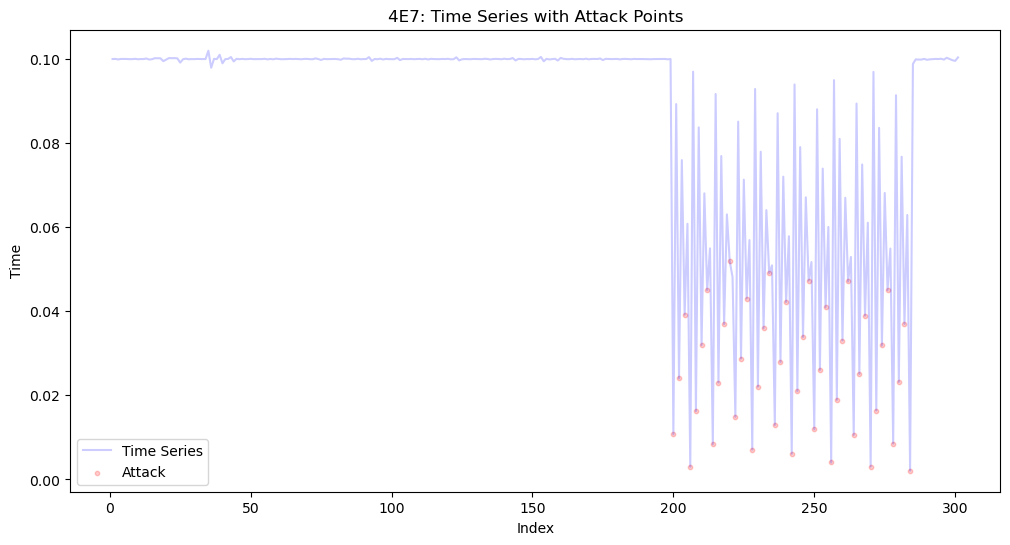

In [12]:
is_attack = valid_data['is_attack'].values

plt.figure(figsize=(12, 6))
plt.plot(valid_data['Time'].diff(), label='Time Series', color='blue', alpha=0.2)

attack_indices = np.where(is_attack == 1)[0]
plt.scatter(attack_indices, valid_data['Time'].diff()[attack_indices], color='red', label='Attack', s=10, alpha=0.2)

plt.title('4E7: Time Series with Attack Points')
plt.xlabel('Index')
plt.ylabel('Time')
plt.legend()

plt.show()

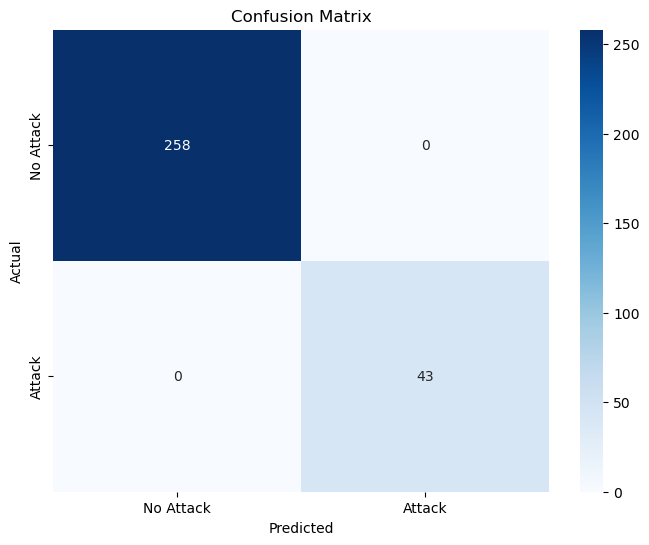

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

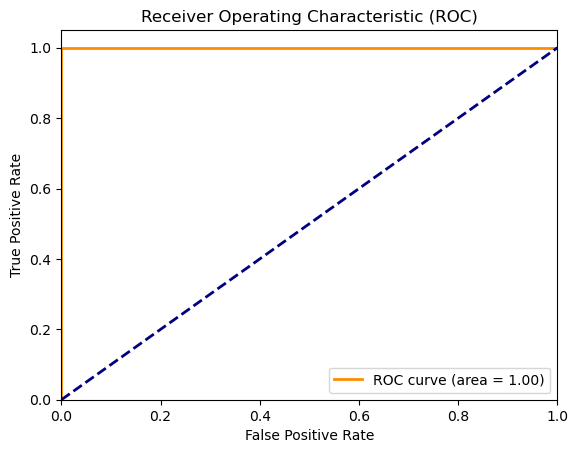

Accuracy: 1.0
Recall: 1.0
Confusion Matrix:
[[258   0]
 [  0  43]]


In [14]:
fpr, tpr, _ = roc_curve(is_attack_actual, is_attack_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")